In [1]:
import tensorflow as tf
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import os
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
import random 

Using TensorFlow backend.


In [2]:
samples = []
with open('../Behavioral_Cloning_In_Keras/New2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    for line in reader:
        samples.append(line)  
print(len(samples))

33546


(100,)
(100,)


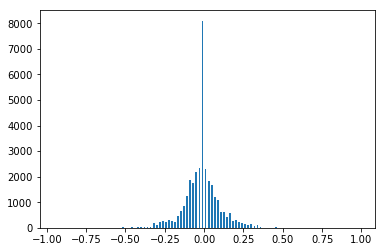

In [3]:
steering = []
for sample in samples:
    steering.append(float(sample[3]))
steering = np.array(steering)

hist, bins = np.histogram(steering, bins = 100)
center = (bins[:-1] + bins[:-1])/2
bin_width = 0.6 * (bins[1]-bins[0])
print(center.shape)
print(hist.shape)
plt.bar(center, hist, width= bin_width)
plt.show()

In [4]:
new_samples = []
for sample in samples:
    if float(sample[3]) == 0:
        if random.uniform(0,1)<0.5:
            new_samples.append(sample)
    else:
        new_samples.append(sample)

(100,)
(100,)


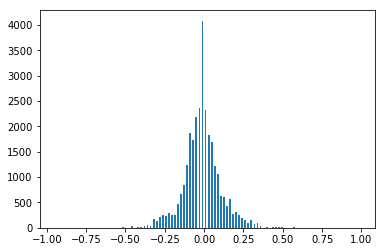

In [5]:
steering = []
for sample in new_samples:
    steering.append(float(sample[3]))
steering = np.array(steering)

hist, bins = np.histogram(steering, bins = 100)
center = (bins[:-1] + bins[:-1])/2
bin_width = 0.6 * (bins[1]-bins[0])
print(center.shape)
print(hist.shape)
plt.bar(center, hist, width= bin_width)
plt.show()

In [6]:
samples = new_samples

../Behavioral_Cloning_In_Keras/New2/IMG/center_2016_12_01_13_30_48_287.jpg


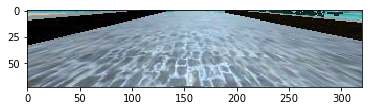

(160, 320, 3)


In [7]:
aws_path = '../Behavioral_Cloning_In_Keras/New2/IMG/'
my_sample = samples[0][0].split('\\')[-1]
my_sample_aws = aws_path + my_sample
print(my_sample_aws)
my_image = cv2.imread(my_sample_aws)

plt.figure()
plt.imshow(my_image[65:138])
plt.show()
print(my_image.shape)

In [8]:
from sklearn.model_selection import train_test_split
import sklearn
from random import shuffle
# Exclude the firt row of the samples which is corrpspiding to the labels as printed above:
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)
print('Training:' ,len(train_samples))
print('Validation:',len(validation_samples))

Training: 23622
Validation: 5906


In [9]:
def generator(samples, batch_size=64):
    aws_path = '../Behavioral_Cloning_In_Keras/New2/IMG/'
    correction = 0.15
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            augmented_images = []
            augmented_angles = []
            
            for batch_sample in batch_samples:
                
                # Image path name
                center_name = aws_path + batch_sample[0].split('\\')[-1]
                left_name = aws_path + batch_sample[1].split('\\')[-1]
                right_name = aws_path + batch_sample[2].split('\\')[-1]
                
                # Images
                center_image_RGB = cv2.imread(center_name)
                center_image = cv2.cvtColor(center_image_RGB, cv2.COLOR_BGR2YUV)
                
                left_image_RGB = cv2.imread(left_name)
                left_image = cv2.cvtColor(left_image_RGB, cv2.COLOR_BGR2YUV)
                
                right_image_RGB = cv2.imread(right_name)
                right_image = cv2.cvtColor(right_image_RGB, cv2.COLOR_BGR2YUV)
                
                # Angles
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Append the images
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                
                # Append the steering angles 
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)
                
                
            for image, angle in zip (images, angles):
                
                augmented_images.append(image)
                augmented_images.append(cv2.flip(image,1))
                
                augmented_angles.append(angle)
                augmented_angles.append(((-1.0)*angle))

            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [10]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
# Keras Model for LeNet-5
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Lambda, Convolution2D, MaxPooling2D, Dropout, Cropping2D, ELU

model = Sequential()
# Normalization Layer
model.add(Lambda(lambda x:x/255.0-0.5, input_shape = (160,320,3)))
# Cropping the images
model.add(Cropping2D(cropping = ((70,25),(0,0))))

model.add(Convolution2D(6,5,5))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), border_mode = 'valid'))

model.add(Convolution2D(16,5,5))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), border_mode = 'valid'))

model.add(Flatten())

model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))

In [12]:
# NVIDIA End to End Learning for Self-Driving Car Network
NVIDIA = Sequential()

NVIDIA.add(Cropping2D(cropping = ((70,25),(0,0)), input_shape = (160,320,3)))
NVIDIA.add(Lambda(lambda x:x/255.0-0.5))

# Conv 1 (5*5)
NVIDIA.add(Convolution2D(24, 5, 5, subsample= (2,2), border_mode= 'valid'))
NVIDIA.add(Activation('relu'))
           
# Conv 2 (5*5)
NVIDIA.add(Convolution2D(36, 5, 5, subsample= (2,2), border_mode= 'valid'))
NVIDIA.add(Activation('relu'))
           
# Conv 3 (5*5)
NVIDIA.add(Convolution2D(48, 5, 5, subsample= (2,2), border_mode= 'valid'))
NVIDIA.add(Activation('relu'))

# Conv 4 (3*3)
NVIDIA.add(Convolution2D(64, 3, 3, border_mode= 'valid'))
NVIDIA.add(Activation('relu'))

# Conv 5 (3*3)           
NVIDIA.add(Convolution2D(64, 3, 3, border_mode= 'valid'))
NVIDIA.add(Activation('relu'))

# Flatten layer
NVIDIA.add(Flatten())

#FC 1
NVIDIA.add(Dense(100))
NVIDIA.add(Dropout(0.5))
NVIDIA.add(Activation('relu'))

#FC 2
NVIDIA.add(Dense(50))
NVIDIA.add(Dropout(0.5))
NVIDIA.add(Activation('relu'))

#FC 3
NVIDIA.add(Dense(10))
NVIDIA.add(Activation('relu'))

#FC 4
NVIDIA.add(Dense(1))

In [13]:
# Train the model
NVIDIA.compile(loss = 'mse', optimizer= 'adam')

NVIDIA.fit_generator(train_generator, samples_per_epoch= 6*len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=4)

NVIDIA.save('NVIDIA.h5')

Epoch 1/4
141732/141732 [==============================] - 294s - loss: 0.0085 - val_loss: 0.0068
Epoch 2/4
141732/141732 [==============================] - 290s - loss: 0.0065 - val_loss: 0.0061
Epoch 3/4
141732/141732 [==============================] - 291s - loss: 0.0060 - val_loss: 0.0062
Epoch 4/4
141732/141732 [==============================] - 291s - loss: 0.0056 - val_loss: 0.0053


In [ ]:
# Train the model
model.compile(loss = 'mse', optimizer= 'adam')

model.fit_generator(train_generator, samples_per_epoch= 6*len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('model.h5')